In [45]:
import os, cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose

from timeit import default_timer as timer

In [8]:
# initialize file paths
cwd = f"{os.getcwd()}/"
image_folder_path = f"{cwd}data/Images/"
annotations_csv_path = f"{cwd}PCB_annotations_dataset.csv"
# initialize image list
image_filenames = os.listdir(image_folder_path)
df_annotations = pd.read_csv(annotations_csv_path, sep=";")

In [9]:
image_data = []
mask_data = []
class_labels = []

grouped_annotations = df_annotations.groupby('filename')

for filename in image_filenames:
    image_path = os.path.join(image_folder_path, filename)
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (600, 600))  
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = image_gray / 255.0 
    image_data.append(image_gray)

    filename = os.path.splitext(filename)[0]
        
    if filename in grouped_annotations.groups:
        df_image_annotation = grouped_annotations.get_group(filename)
        class_label = df_image_annotation['defect'].iloc[0]
        mask = np.zeros_like(image_gray, dtype=np.uint8)
        for _, row in df_image_annotation.iterrows():
            x = int(row['xmin'])
            y = int(row['ymin'])
            w = int(row['xmax']-row['xmin']+1)
            h = int(row['ymax']-row['ymin']+1) 
            mask[y:y+h, x:x+w] = 1
        class_labels.append(class_label)
        mask_data.append(mask)
    else:
        print(f"Image {filename} not found in 'PCB_annotations_dataset.csv'")

X_images = np.asarray(image_data)
y_masks = np.asarray(mask_data)
y_labels = np.asarray(class_labels)

encoder = LabelEncoder()

y_labels_enc = encoder.fit_transform(y_labels)
y_labels_cat = to_categorical(y_labels_enc).astype('uint8')

label_mapping = {index: label for index, label in enumerate(encoder.classes_)}


In [10]:
print(f"Shape/type of X_images: {X_images.shape}/{type(X_images)}/{X_images.dtype}")
print(f"Shape/type of y_masks: {y_masks.shape}/{type(y_masks)}/{y_masks.dtype}")
print(f"Shape/type of y_labels_cat: {y_labels_cat.shape}/{type(y_labels_cat)}/{y_labels_cat.dtype}")

Shape/type of X_images: (300, 600, 600)/<class 'numpy.ndarray'>/float64
Shape/type of y_masks: (300, 600, 600)/<class 'numpy.ndarray'>/uint8
Shape/type of y_labels_cat: (300, 6)/<class 'numpy.ndarray'>/uint8


In [11]:
# crop the images and masks to (100, 100)
new_size = (100, 100)

def crop_images(X_images, y_masks, y_labels_cat, new_size):
    if not all(new < orig and orig % new == 0 for orig, new in zip((600, 600), new_size)):
        print("New size must be smaller and a divisor of the original size.")
        return False

    cropped_images = []
    cropped_masks = []
    cropped_labels_cat = []


    for image, mask, labels in zip(X_images, y_masks, y_labels_cat):
        for y in range(0, 600, 100):
            for x in range(0, 600, 100):
                y0, x0 = y, x
                y100, x100 = y+100, x+100
                # if a bounding box crosses the cropping border, shift the corresponding border, so defects are not cut off
                while( np.any(mask[y0, x0:x100])) and (y0 != 0): 
                    y0 -= 1
                while (np.any(mask[min(y100, 599), x0:x100])) and (y100 != 600):
                    y100 += 1
                while( np.any(mask[y0:y100, x0])) and (x0 != 0):
                    x0 -= 1
                while( np.any(mask[y0:y100, min(x100, 599)])) and (x100 != 600):
                    x100 += 1
                patch_image = cv2.resize(image[y0:y100, x0:x100], new_size)
                patch_mask = cv2.resize(mask[y0:y100, x0:x100], new_size)
                if np.any(patch_mask):
                    cropped_images.append(patch_image)
                    cropped_masks.append(patch_mask)
                    cropped_labels_cat.append(labels)

    cropped_images = np.array(cropped_images)
    cropped_masks = np.array(cropped_masks)
    cropped_labels_cat = np.array(cropped_labels_cat)
    return cropped_images, cropped_masks, cropped_labels_cat

cropped_images, cropped_masks, cropped_labels_cat = crop_images(X_images, y_masks, y_labels_cat, new_size)

In [12]:
print(f"Shape/type of cropped_images: {cropped_images.shape} / {type(cropped_images)} / {cropped_images.dtype}")
print(f"Shape/type of cropped_masks: {cropped_masks.shape} / {type(cropped_masks)} / {cropped_masks.dtype}")
print(f"Shape/type of cropped_labels_cat: {cropped_labels_cat.shape} / {type(cropped_labels_cat)} / {cropped_labels_cat.dtype}")

Shape/type of cropped_images: (986, 100, 100) / <class 'numpy.ndarray'> / float64
Shape/type of cropped_masks: (986, 100, 100) / <class 'numpy.ndarray'> / uint8
Shape/type of cropped_labels_cat: (986, 6) / <class 'numpy.ndarray'> / uint8


In [13]:
# check for empty masks
for index, mask in enumerate(cropped_masks):
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) == 0:
        print(index)

In [14]:
# the functions in this cell all serve the following purpose:
# - detect images with exactly two objects in the cropped dataset
# - it does not work yet for the case that there are more than two in an image
# - split those images in two new images
# - replace the original image with two objects with the two single object images

# project the pixel mask onto the x- and y-axis
def compute_projections(mask):
    horizontal_projection = np.sum(mask, axis=1)
    vertical_projection = np.sum(mask, axis=0)
    
    return horizontal_projection, vertical_projection

# list all nonzero blocks in an axis-projection as a dictionary {index: block_length}
def find_nonzero_blocks(projection):
    blocks = {}
    block_length = 0
    for index, value in enumerate(projection):
        if value > 0:
            if block_length == 0:
                key = index
            block_length += 1
        else:
            if block_length > 0:
                blocks[key] = block_length
                block_length = 0
    
    if block_length > 0:
        blocks[key] = block_length

    return blocks

# find indices of images with multiple objects in the cropped_dataset including the x- and y-projections of the objects in the format {index: width}
def find_mult_obj_images():
    mult_obj = []
    for index, mask in enumerate(cropped_masks):
        py, px = compute_projections(mask)
        nzby, nzbx = (find_nonzero_blocks(p) for p in (py, px))
        if any((len(nzbx) > 1, len(nzby) > 1)):
            mult_obj.append((index, nzbx, nzby))
    return(mult_obj)

# find and return the index of the first occurence of an image with multiple objects including the x- and y-projections of the objects in the format {index: width}
def find_mult_obj_mask(masks_aray):
    for index, mask in enumerate(masks_aray):
        py, px = compute_projections(mask)
        nzby, nzbx = (find_nonzero_blocks(p) for p in (py, px))
        if any((len(nzbx) > 1, len(nzby) > 1)):
            mult_obj = (index, nzbx, nzby)
            return(mult_obj)
    return False

# takes the output of 'find_mult_obj_mask' and splits the image along the axis along which the two objects have the maximal distance
# does not work for more than two objects yet
def separate_objects(images, masks, mult_object_mask_data):
    index, obj_x, obj_y = mult_object_mask_data

    if any(len(obj) > 2 for obj in (obj_x, obj_y)):
        print("More than two objects on image {index}. Please adapt the function 'separate_objects'.")
        return False
    
    mask = masks[index]
    image = images[index]
    
    left_gap_border = min(obj_x) + obj_x[min(obj_x)]
    right_gap_border = max(obj_x)
    upper_gap_border = min(obj_y) + obj_y[min(obj_y)]
    bottom_gap_border = max(obj_y)
    
    dist_x = right_gap_border - left_gap_border + 1
    dist_y = bottom_gap_border - upper_gap_border + 1
    
    if dist_x >= dist_y:
        sep_position = left_gap_border+dist_x//2
        
        split1_mask = mask[:, :sep_position]
        split2_mask = mask[:, sep_position:]
        split1_image = image[:, :sep_position]
        split2_image = image[:, sep_position:]            
        
        split1_mask = cv2.resize(split1_mask, (100, 100))
        split2_mask = cv2.resize(split2_mask, (100, 100))
        split1_image = cv2.resize(split1_image, (100, 100))
        split2_image = cv2.resize(split2_image, (100, 100))
    else:
        sep_position = upper_gap_border+dist_y//2

        split1_mask = mask[:sep_position, :]
        split2_mask = mask[sep_position:, :]
        split1_image = image[:sep_position, :]
        split2_image = image[sep_position:, :]
                    
        split1_mask = cv2.resize(split1_mask, (100, 100))
        split2_mask = cv2.resize(split2_mask, (100, 100))
        split1_image = cv2.resize(split1_image, (100, 100))
        split2_image = cv2.resize(split2_image, (100, 100))
    
    splitted = (index, [split1_image, split2_image], [split1_mask, split2_mask])
    
    return(splitted)

# replaces images with two objects with two images with one object each as long as there are images with two objects. 
# does not work if there are images with more than two objects
def split_and_replace_mult_obj_data():
    cropped_images_process = cropped_images
    cropped_masks_process = cropped_masks
    cropped_labels_cat_process = cropped_labels_cat
    
    while (mult_obj := find_mult_obj_mask(cropped_masks_process)):
        index, split_images, split_masks = separate_objects(cropped_images_process, cropped_masks_process, mult_obj)
        cropped_images_process = np.delete(cropped_images_process, index, axis=0)
        cropped_images_process = np.append(cropped_images_process, split_images, axis=0)

        cropped_masks_process = np.delete(cropped_masks_process, index, axis=0)
        cropped_masks_process = np.append(cropped_masks_process, split_masks, axis=0)
        
        label = cropped_labels_cat_process[index]
        cropped_labels_cat_process = np.delete(cropped_labels_cat_process, index, axis=0)
        cropped_labels_cat_process = np.append(cropped_labels_cat_process, [label, label], axis=0)
    
    return(cropped_images_process, cropped_masks_process, cropped_labels_cat_process)


Number of multiple object images: 18


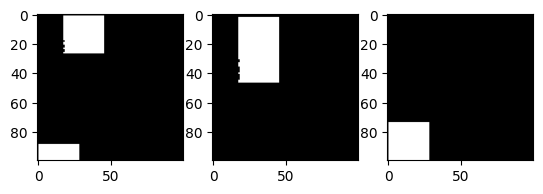

In [15]:
# check the splitting of a chosen example
mult_obj_img_lst = find_mult_obj_images()
print(f"Number of multiple object images: {len(mult_obj_img_lst)}")
mobj = mult_obj_img_lst[17] # enter an index here
index, _, [split1_mask, split2_mask] = separate_objects(cropped_images, cropped_masks, mobj)
plt.subplot(131)
plt.imshow(cropped_masks[mobj[0]], cmap='gray')
plt.subplot(132)
plt.imshow(split1_mask, cmap='gray')
plt.subplot(133)
plt.imshow(split2_mask, cmap='gray')
cnt, _ = cv2.findContours(split1_mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

In [16]:
cropped_images_no_mult, cropped_masks_no_mult, cropped_labels_cat_no_mult = split_and_replace_mult_obj_data()

In [17]:
# check for empty masks
for index, mask in enumerate(cropped_masks_no_mult):
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) == 0:
        print(index)

In [18]:
# check for multiple object images again
find_mult_obj_mask(cropped_masks_no_mult)

False

In [19]:
# check dimensions
print(f"Shape of cropped_images: {cropped_images.shape}")
print(f"Shape of cropped_masks: {cropped_masks.shape}")
print(f"Shape of cropped_labels_cat: {cropped_labels_cat.shape}")
print(f"Shape of cropped_images_no_mult: {cropped_images_no_mult.shape}")
print(f"Shape of cropped_masks_no_mult: {cropped_masks_no_mult.shape}")
print(f"Shape of cropped_labels_cat_no_mult: {cropped_labels_cat_no_mult.shape}")

Shape of cropped_images: (986, 100, 100)
Shape of cropped_masks: (986, 100, 100)
Shape of cropped_labels_cat: (986, 6)
Shape of cropped_images_no_mult: (1004, 100, 100)
Shape of cropped_masks_no_mult: (1004, 100, 100)
Shape of cropped_labels_cat_no_mult: (1004, 6)


In [20]:
# Split data into train and validation sets
X_train, X_test, y_train_masks, y_test_masks, y_train_labels_cat, y_test_labels_cat = train_test_split(cropped_images_no_mult, cropped_masks_no_mult, cropped_labels_cat_no_mult, 
                                                                                                      test_size=0.2, random_state=666)

In [21]:
# check dimensions
print("X_train shape:", X_train.shape)
print("y_train_mask shape:", y_train_masks.shape)
print("y_train_labels_cat shape:", y_train_labels_cat.shape)
print("X_test shape:", X_test.shape)  
print("y_test_masks shape:", y_test_masks.shape)
print("y_test_labels_cat shape:", y_test_labels_cat.shape)

X_train shape: (803, 100, 100)
y_train_mask shape: (803, 100, 100)
y_train_labels_cat shape: (803, 6)
X_test shape: (201, 100, 100)
y_test_masks shape: (201, 100, 100)
y_test_labels_cat shape: (201, 6)


In [22]:
# Data Augmentation:
# rotation ,width_shift, height_shift, shear, zoom, horizontal_flip

def augment_data(images, masks, labels):
    augmented_images = []
    augmented_masks = []
    augmented_labels = []

    for image, mask, label in zip(images, masks, labels):
        augmented_images.append(image)
        augmented_masks.append(mask)
        augmented_labels.append(label)

        shear_image, shear_mask = shear(image, mask)
        augmented_images.append(shear_image)
        augmented_masks.append(shear_mask)
        augmented_labels.append(label)
        # print("Shear:", shear_image.shape, shear_mask.shape)

        flip_image, flip_mask = flip(image, mask)
        augmented_images.append(flip_image)
        augmented_masks.append(flip_mask)
        augmented_labels.append(label)
        # print("Flip:", flip_image.shape, flip_mask.shape)

        zoom_image, zoom_mask = zoom(image, mask)
        augmented_images.append(zoom_image)
        augmented_masks.append(zoom_mask)
        augmented_labels.append(label)
        # print("Zoom:", zoom_image.shape, zoom_mask.shape)

        width_shift_image, width_shift_mask = width_shift(image, mask)
        augmented_images.append(width_shift_image)
        augmented_masks.append(width_shift_mask)
        augmented_labels.append(label)
        # print("Width Shift:", width_shift_image.shape, width_shift_mask.shape)

        height_shift_image, height_shift_mask = height_shift(image, mask)
        augmented_images.append(height_shift_image)
        augmented_masks.append(height_shift_mask)
        augmented_labels.append(label)
        # print("Height Shift:", height_shift_image.shape, height_shift_mask.shape)

        rotate_image, rotate_mask = rotate(image, mask)
        augmented_images.append(rotate_image)
        augmented_masks.append(rotate_mask)
        augmented_labels.append(label)
        # print("Rotation:", rotate_image.shape, rotate_mask.shape)

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_masks, augmented_labels

def shear(image, mask):
    shear_factor = np.random.uniform(-0.2, 0.2)
    rows, cols = image.shape[:2]
    shear_matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    shear_image = cv2.warpAffine(image, shear_matrix, (cols, rows))
    shear_mask = cv2.warpAffine(mask, shear_matrix, (cols, rows))

    padded_image = np.zeros((100, 100), dtype=np.uint8)
    padded_mask = np.zeros((100, 100), dtype=np.uint8)
    padded_image[:rows, :cols] = shear_image
    padded_mask[:rows, :cols] = mask

    return shear_image, shear_mask

def flip(image, mask):
    flip_image = cv2.flip(image, 1)
    flip_mask = cv2.flip(mask, 1)
    return flip_image, flip_mask

def zoom(image, mask):
    zoom_factor = np.random.uniform(0.8, 1.2)
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    zoomed_mask = cv2.resize(mask, None, fx=zoom_factor, fy=zoom_factor)

    rows, cols = zoomed_image.shape[:2]
    if rows < 100 or cols < 100:
        pad_rows = max(0, (100 - rows) // 2)
        pad_cols = max(0, (100 - cols) // 2)
        zoomed_image = cv2.copyMakeBorder(zoomed_image, pad_rows, 100 - rows - pad_rows, pad_cols, 100 - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
        zoomed_mask = cv2.copyMakeBorder(zoomed_mask, pad_rows, 100 - rows - pad_rows, pad_cols, 100 - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
    elif rows > 100 or cols > 100:
        zoomed_image = zoomed_image[:100, :100]
        zoomed_mask = zoomed_mask[:100, :100]

    return zoomed_image, zoomed_mask

def width_shift(image, mask):
    shift_x = np.random.uniform(-0.2, 0.2) * image.shape[1]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, 0]])
    width_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    width_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if width_shift_image.shape[1] > 100:
        width_shift_image = width_shift_image[:, :100]
        width_shift_mask = width_shift_mask[:, :100]
    elif width_shift_image.shape[1] < 100:
        pad_width = 100 - width_shift_image.shape[1]
        width_shift_image = np.pad(width_shift_image, ((0, 0), (0, pad_width), (0, 0)), mode='constant')
        width_shift_mask = np.pad(width_shift_mask, ((0, 0), (0, pad_width), (0, 0)), mode='constant')

    return width_shift_image, width_shift_mask

def height_shift(image, mask):
    shift_y = np.random.uniform(-0.2, 0.2) * image.shape[0]
    translation_matrix = np.float32([[1, 0, 0], [0, 1, shift_y]])
    height_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    height_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if height_shift_image.shape[0] > 100:
        height_shift_image = height_shift_image[:100, :]
        height_shift_mask = height_shift_mask[:100, :]
    elif height_shift_image.shape[0] < 100:
        pad_height = 100 - height_shift_image.shape[0]
        height_shift_image = np.pad(height_shift_image, ((0, pad_height), (0, 0), (0, 0)), mode='constant')
        height_shift_mask = np.pad(height_shift_mask, ((0, pad_height), (0, 0), (0, 0)), mode='constant')

    return height_shift_image, height_shift_mask

def rotate(image, mask):
    angle = np.random.uniform(-20, 20)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotate_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    rotate_mask = cv2.warpAffine(mask, rotation_matrix, (cols, rows))

    if rotate_image.shape[0] > 100 or rotate_image.shape[1] > 100:
        rotate_image = cv2.resize(rotate_image, (100, 100))
        rotate_mask = cv2.resize(rotate_mask, (100, 100))
    elif rotate_image.shape[0] < 100 or rotate_image.shape[1] < 100:
        pad_height = max(0, 100 - rotate_image.shape[0])
        pad_width = max(0, 100 - rotate_image.shape[1])
        rotate_image = np.pad(rotate_image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        rotate_mask = np.pad(rotate_mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    return rotate_image, rotate_mask


In [23]:
X_train_augmented, y_train_masks_augmented, y_train_labels_cat_augmented = augment_data(X_train, y_train_masks, y_train_labels_cat)

In [24]:
# check dimensions
print("X_train shape:", X_train.shape)
print("y_train_masks shape:", y_train_masks.shape)
print("y_train_labels_cat shape:", y_train_labels_cat.shape)

print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_masks_augmented shape:", y_train_masks_augmented.shape)
print("y_train_labels_cat_augmented shape:", y_train_labels_cat_augmented.shape)

X_train shape: (803, 100, 100)
y_train_masks shape: (803, 100, 100)
y_train_labels_cat shape: (803, 6)
X_train_augmented shape: (5621, 100, 100)
y_train_masks_augmented shape: (5621, 100, 100)
y_train_labels_cat_augmented shape: (5621, 6)


In [25]:
# check for empty masks that were potentially produced by augmentation and remove those data
def detect_no_object_data(masks):
    for index, mask in enumerate(masks):
        cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
        if len(cnt) == 0:
            return(index)
    return False   
    
def remove_no_object_data(index, images, masks, labels):
    updated_images = np.delete(images, index, axis=0)
    updated_masks = np.delete(masks, index, axis=0)
    updated_labels = np.delete(labels, index, axis=0)
    return(updated_images, updated_masks, updated_labels)

while (index := detect_no_object_data(y_train_masks_augmented)):
    X_train_augmented, y_train_masks_augmented, y_train_labels_cat_augmented = remove_no_object_data(index, X_train_augmented, y_train_masks_augmented, y_train_labels_cat_augmented)
    

In [26]:
def build_bboxes_channel(masks):
    bboxes = []
    for index, mask in enumerate(masks):
        cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
        if len(cnt) == 1:
            x, y, w, h = cv2.boundingRect(cnt[0])
            bbox = np.array([x, y, w, h])
            #combined_array = np.expand_dims(X_train_augmented[index], axis=-1)
            #combined_array = np.repeat(combined_array, 4, axis=-1)
            #combined_array[2] = bbox_array
            bboxes.append(bbox)
        else:
            print("No or mutliple object(s) in image {index}.")
    bboxes = np.asarray(bboxes).astype('uint8')
    return(bboxes)


In [27]:
# add a bounding box channel to the train and test set
y_train_bboxes_augmented = build_bboxes_channel(y_train_masks_augmented)
y_test_bboxes = build_bboxes_channel(y_test_masks)

In [28]:
# check dimensions
print("X_train shape:", X_train.shape)
print("y_train_masks shape:", y_train_masks.shape)
print("y_train_labels_cat shape:", y_train_labels_cat.shape)

print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_masks_augmented shape:", y_train_masks_augmented.shape)
print("y_train_bboxes_augmented shape:", y_train_bboxes_augmented.shape)
print("y_train_labels_cat_augmented shape:", y_train_labels_cat_augmented.shape)

print("X_test shape:", X_test.shape)
print("y_test_masks shape:", y_test_masks.shape)
print("y_test_bboxes shape:", y_test_bboxes.shape)


X_train shape: (803, 100, 100)
y_train_masks shape: (803, 100, 100)
y_train_labels_cat shape: (803, 6)
X_train_augmented shape: (5609, 100, 100)
y_train_masks_augmented shape: (5609, 100, 100)
y_train_bboxes_augmented shape: (5609, 4)
y_train_labels_cat_augmented shape: (5609, 6)
X_test shape: (201, 100, 100)
y_test_masks shape: (201, 100, 100)
y_test_bboxes shape: (201, 4)


In [29]:
# Combining images and masks into tuples
combined_data = list(zip(X_train_augmented, y_train_masks_augmented, y_train_bboxes_augmented, y_train_labels_cat_augmented))


In [30]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [31]:
early_stopping = EarlyStopping(
                                patience=2, 
                                min_delta = 0.005, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, 
                                    episilon= 0.01,
                                    factor=0.1,  
                                    cooldown = 2, 
                                    verbose=1)

time_callback = TimingCallback()


In [37]:
def enhanced_unet(input_shape):
    input = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(32, 5, activation='relu', padding='same')(input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)

    # Decoder
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv3)
    up1 = Concatenate(axis=3)([up1, conv2])
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(up1)

    up2 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv4)
    up2 = Concatenate(axis=3)([up2, conv1])
    conv5 = Conv2D(32, 5, activation='relu', padding='same')(up2)

    # Output
    #output= Conv2D(1, 1, activation='sigmoid')(conv5)
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='segmentation')(conv5)
    flatten_layer = Flatten()(conv5)
    bbox_output = Dense(4, activation='linear')(flatten_layer)
    #model = models.Model(inputs=input, outputs=output)
    model = models.Model(inputs=input, outputs=[segmentation_output, bbox_output])
    return model


In [38]:
# Instantiate the model
model = enhanced_unet(input_shape=(100, 100, 1))

In [125]:
a = np.array([[[1,2], [3,4], [5,6]], [[10,20], [30,40], [50,60]]])
print(a.shape)

(2, 3, 2)


In [39]:
def combined_loss(y_true, y_pred):
    # Segmentation loss (binary cross-entropy)
    segm_true = y_true[..., 0]
    segm_pred = y_pred[..., 0]
    segm_loss = binary_crossentropy(segm_true, segm_pred)
    
    # Bounding box loss (Mean Squared Error)
    bbox_true = y_true[..., 1:]
    bbox_pred = y_pred[..., 1:]
    bbox_loss = mean_squared_error(bbox_true, bbox_pred)
    
    # Weights for segmentation and bounding box loss
    alpha = 0.8  # Weight for segmentation loss
    beta = 0.2   # Weight for bounding box loss
    
    # Combined loss
    combined_loss = alpha * segm_loss + beta * bbox_loss
    
    return combined_loss


In [40]:
# Compile the model
model.compile(optimizer='adam',
              #loss='binary_crossentropy',
              loss=combined_loss,  
              metrics=['accuracy', 'mae'])  

In [41]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 100, 100,  │        832 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 25, 25,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 25, 25,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 50, 50,    │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 50, 50,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 50, 50,    │     73,792 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 100, 100,  │      8,224 │ conv2d_8[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 100, 100,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 100, 100,  │     51,232 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 320000)    │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segmentation        │ (None, 100, 100,  │         33 │ conv2d_9[0][0]    │
│ (Conv2D)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │  1,280,004 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,539,301 (5.87 MB)

 Trainable params: 1,539,301 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True);

In [43]:
print(f"X_train_augmented shape: {type(X_train_augmented)}, {X_train_augmented.shape}")
print(f"y_train_masks_augmented shape: {type(y_train_masks_augmented)}, {y_train_masks_augmented.shape}")
print(f"y_train_bboxes_augmented shape: {type(y_train_bboxes_augmented)}, {y_train_bboxes_augmented.shape}")
print(f"y_train_labels_cat_augmented shape: {type(y_train_labels_cat_augmented)}, {y_train_labels_cat_augmented.shape}")

print("X_test shape:", X_test.shape)
print("y_test_masks shape:", y_test_masks.shape)
print("y_test_bboxes shape:", y_test_bboxes.shape)

print("Expected input shape for the model:", model.input_shape)

print("Model output shape:", model.output_shape)

print("Data type of y_train_masks_augmented:", y_train_masks_augmented.dtype)
print("Data type of y_train_bboxes_augmented:", y_train_bboxes_augmented.dtype)

X_train_augmented shape: <class 'numpy.ndarray'>, (5609, 100, 100)
y_train_masks_augmented shape: <class 'numpy.ndarray'>, (5609, 100, 100)
y_train_bboxes_augmented shape: <class 'numpy.ndarray'>, (5609, 4)
y_train_labels_cat_augmented shape: <class 'numpy.ndarray'>, (5609, 6)
X_test shape: (201, 100, 100)
y_test_masks shape: (201, 100, 100)
y_test_bboxes shape: (201, 4)
Expected input shape for the model: (None, 100, 100, 1)
Model output shape: [(None, 100, 100, 1), (None, 4)]
Data type of y_train_masks_augmented: uint8
Data type of y_train_bboxes_augmented: uint8


In [44]:
# Train the model
history = model.fit(x=X_train_augmented, 
                    y=[y_train_masks_augmented, y_train_bboxes_augmented],
                    epochs=16,
                    batch_size=32,
                    validation_data=(X_test, [y_test_masks, y_test_bboxes]),
                    callbacks=[reduce_learning_rate, time_callback],
                    verbose=True)

Epoch 1/16


OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.

In [246]:
saved_model = model.save('model_unet_trained_on_2x50.keras')

In [247]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

train_mae = history.history["mae"]
val_mae = history.history["val_mae"]


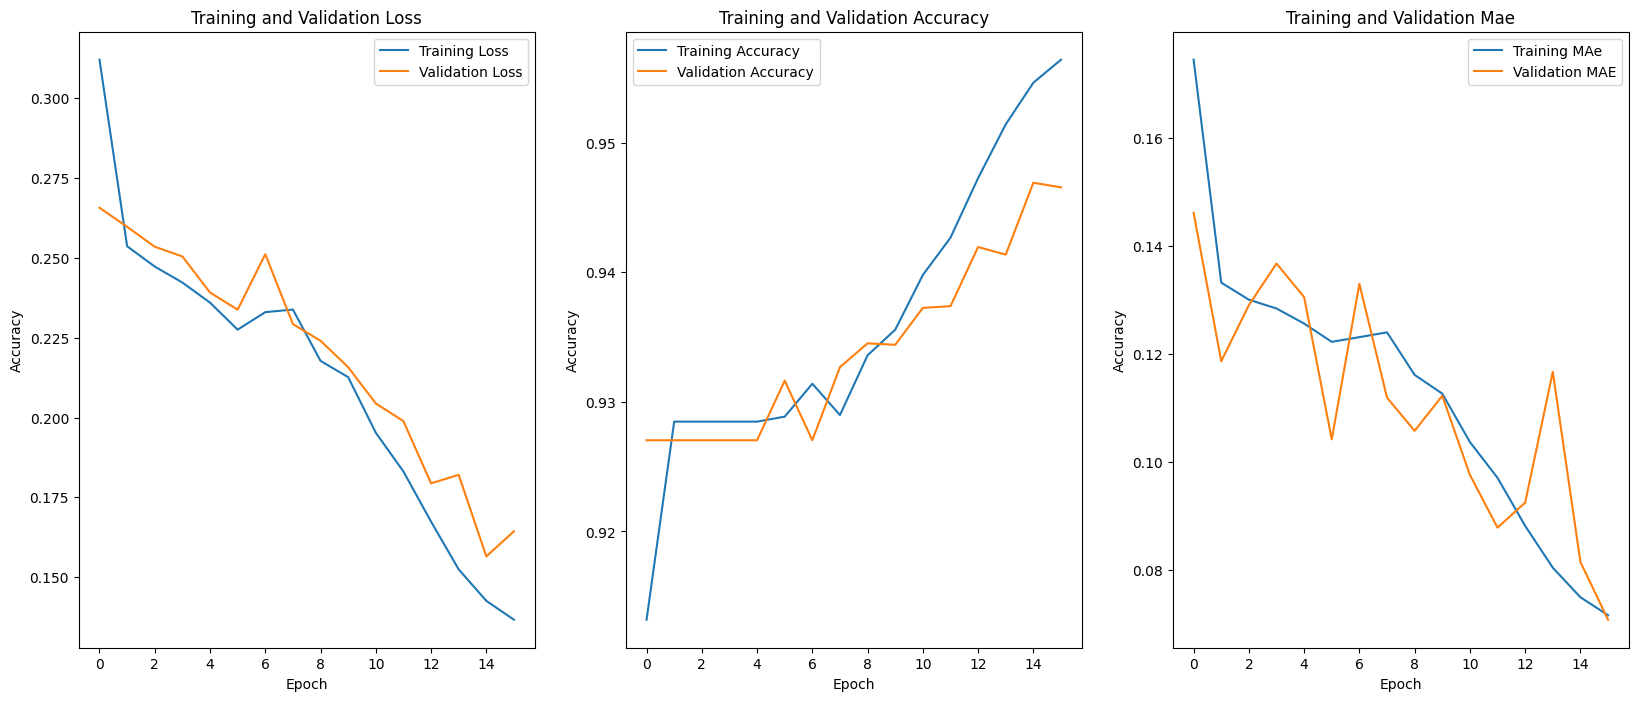

In [248]:

plt.figure(figsize = (20, 8))

plt.subplot(131)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(132)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.subplot(133)
plt.plot(train_mae, label="Training MAe")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Mae")
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


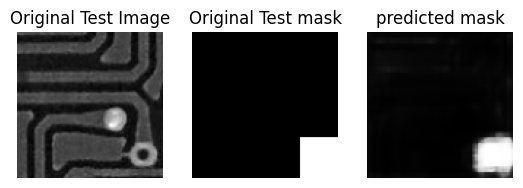

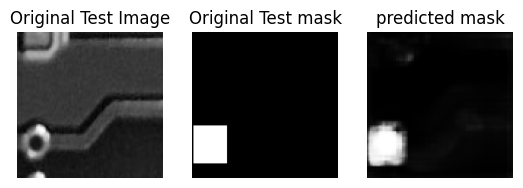

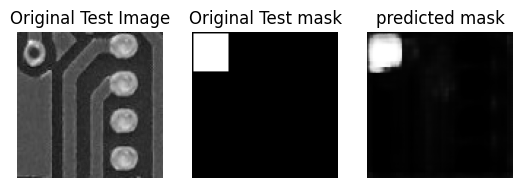

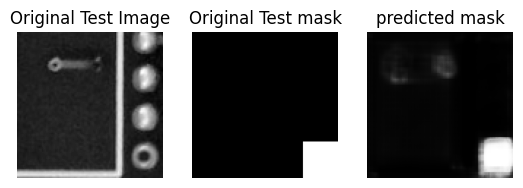

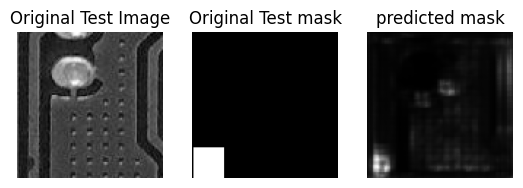

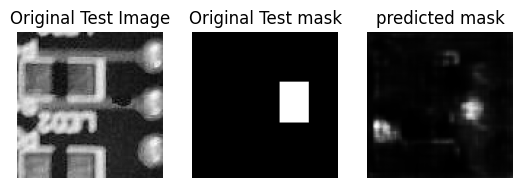

In [249]:
y_val_pred = model.predict(X_test)

for i in np.random.choice(X_test.shape[0], replace=False, size=6):

    plt.subplot(131) 
    plt.imshow(X_test[i].squeeze(), cmap='gray')  
    plt.title('Original Test Image')
    plt.axis('off')

    plt.subplot(132)  
    plt.imshow(y_test_mask[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask')
    plt.axis('off')

    plt.subplot(133)  
    plt.imshow(y_val_pred[i].squeeze(), cmap='gray')  
    plt.title('predicted mask')
    plt.axis('off')

    plt.show()
    